In [1]:
import numpy as np
from numpy import sqrt, exp, sinh

# interactive plots
#%matplotlib notebook
# nice inline plots
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = 16, 9

#### Plotting Helpers

In [2]:
def common_plt(title, xlabel, ylabel, xlim=None, ylim=None, xone=True, yone=True, legend=True):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlim: plt.xlim(xlim[0], xlim[1])
    if ylim: plt.ylim(ylim[0], ylim[1])
    if xone: plt.axvline(1,color='g',linestyle='--')
    if yone: plt.axhline(1,color='g',linestyle='--')
    if legend: plt.legend()
    plt.show()

def common_plt_potential(*args):
    plt.gcf().set_size_inches(6,5)
    plt.ylim(0,1.1)
    xs = np.linspace(-0.5, 5.5, num=100)
    for pot in args:
        try:
            plt.plot(xs, [pot(x) for x in xs])
        except:
            plt.plot(xs, [pot[0](x) for x in xs], pot[1])
    plt.show()

# Numerov's Method

#### Single Step

This corresponds to the $\psi_{n+1}=f(\psi_{n}, \psi_{n-1})$ sixth order formula.

In [3]:
def numerov_step(k0, k1, k2, psi0, psi1, dx):
    """compute psi2 via a single numerov step"""
    dd = dx**2/12.
    c0 = (1 + dd * k0)
    c1 = 2 * (1 - 5 * dd * k1)
    c2 = (1 + dd * k2)
    # assert not np.isclose(c2, 0.) # slow!
    return (c1 * psi1 - c0 * psi0) / c2

As a basic test, let's check the "symmetry property" of a single Numerov step:

In [4]:
assert np.isclose(numerov_step(2, 4, 7, numerov_step(7, 4, 2, 2, 4, .25), 4, .25), 2)

#### Low-Level Numerov

Iterate to obtain all $\psi_{n}$, given all $k$ values, two starting points and the discretisation step.

In [5]:
def numerov_iter(ks, psi0, psi1, dx):
    """compute psis = [psi0, psi1, psi2, ...] for ks = [k0, k1, ...] via iterated numerov steps"""
    n = len(ks)
    psis = np.zeros(n, dtype=np.complex128)
    psis[0] = psi0
    psis[1] = psi1
    for i in range(2, n):
        psis[i] = numerov_step(ks[i-2], ks[i-1], ks[i], psis[i-2], psis[i-1], dx)
    return psis

#### High-Level Numerov

Here we chose between left-to-right and right-to-left evolution.

In [6]:
def numerov(k, psi0, psi1, x_min, x_max, n):
    """compute psis = [psi0, psi1, ...] for k = k(x) according to given discretization"""
    xs, dx = np.linspace(x_min, x_max, num=n, retstep=True)
    ks = np.vectorize(k)(xs)
    return xs, numerov_iter(ks, psi0, psi1, dx)

def numerov_right_to_left(k, psi_2ndlast, psi_last, x_min, x_max, n):
    """compute psis = [..., psi_2ndlast, psi_last] for k = k(x) according to given discretization"""
    xs, dx = np.linspace(x_min, x_max, num=int(n), retstep=True)
    ks = np.vectorize(k)(xs)
    return xs, numerov_iter(ks[::-1], psi_last, psi_2ndlast, dx)[::-1]

# Scattering

Obtain $T,R$ by calculating $\psi_L=A\exp(iqx)+B\exp(iqx)$ from $\psi_R=C\exp(iqx)$ and solving for $A,B$ (with $C=1$).

In [7]:
def scatter(V, E, x_min, x_max, n, return_xs_psis=False):
    """compute transmission & reflection coefficient for given potential and energy (and m = hbar = 1)"""
    # compute step size
    dx = (x_max - x_min) / float(n)

    # start with right-travling wave at energy E (w/ phase fixed to 1 at x_max)
    q_free = sqrt(2. * E)
    psi_2nd_last = 1
    psi_last = exp(1j * q_free * dx)

    # compute resulting solution using Numerov
    k = lambda x: 2*(E-V(x))
    xs, psis = numerov_right_to_left(k, psi_2nd_last, psi_last, x_min - dx, x_max + dx, n + 2)
    
    # fit psis[] to A * exp(iqx) + B * exp(-iqx)
    A, B = np.linalg.solve(
        [[exp(1j*q_free*(-dx)), exp(-1j*q_free*(-dx))],
         [1, 1]],
        [psis[0], psis[1]])
    
    # extract transmission and reflection coefficients
    T = 1 / abs(A)**2
    R = abs(B)**2 / abs(A)**2
    return (T, R, xs, psis) if return_xs_psis else (T, R)

"Test" with a free particle, which should be fully transmitted:

In [9]:
assert np.allclose(scatter(V=lambda _: 0, E=1, x_min=0, x_max=1, n=1e5), [1, 0])

## Rectangular Potential

In [9]:
def rect_potential(a):
    def V(x):
        return float(0 < x <= a)
    return V

common_plt_potential(rect_potential(a=5))

#### Wave Function

This is a bit of a hack...

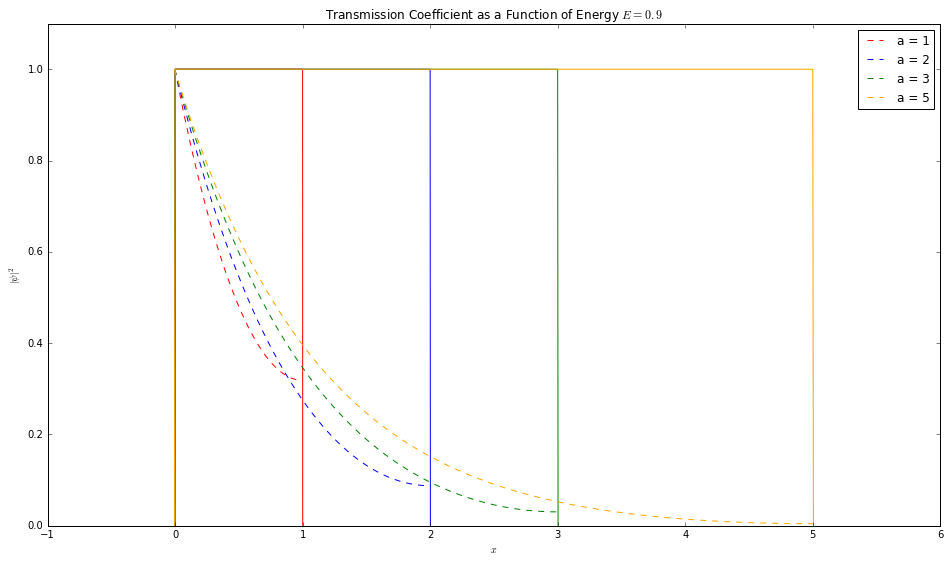

In [11]:
E=0.9
for a, color in zip([1, 2, 3, 5], ['red', 'blue', 'green', 'orange']):
    V = rect_potential(a=a)
    T, _, xs, psis = scatter(V=V, E=E, x_min=0, x_max=a, n=1000, return_xs_psis=True)
    plt.plot(xs, [V(x) for x in xs], color=color)
    plt.plot(xs, np.abs(psis)**2/np.abs(psis[0])**2, '--', color=color, label='a = %s' % a)

common_plt('Transmission Coefficient as a Function of Energy $E = %s$' % E, '$x$', '$|\psi|^2$',
           [-1,6], [0,1.1], xone=False, yone=False)

#### Analytical expression for the transmission probability:

In [12]:
def transmission_exact(a, E):
    assert not np.isclose(E,1.)
    kappa = sqrt(2 * (1-E)+0j)
    return 1. / (1 + sinh(kappa*a)**2 / (4. * E * (1-E))).real

#### Convergence to the Analytical Value

In [13]:
a = 2.5
V = rect_potential(a=a)
Es = [0.71, 0.91]
Ts_exact = [transmission_exact(a=a, E=E) for E in Es]
step_sizes = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

for E, T_exact in zip(Es, Ts_exact):
    # show theoretical value as horizontal line
    plt.axhline(T_exact, color='gray')
    
    # plot numerical data points
    Ts_approx = [scatter(V=V, E=E, x_min=0, x_max=a, n=int(np.ceil(a / dx)))[0] for dx in step_sizes]
    plt.semilogx(step_sizes, Ts_approx, 'o', label='$E=%s$' % E)

plt.yticks(Ts_exact)
common_plt('Convergence of Transmission Coefficient for a = %f and E = %s' % (a, ', '.join(map(str, Es))),
           '$\Delta x$', '$T$', ylim=[0,0.2])

This tells us that want $\Delta x<=0.01$.

#### Dependence on Energy

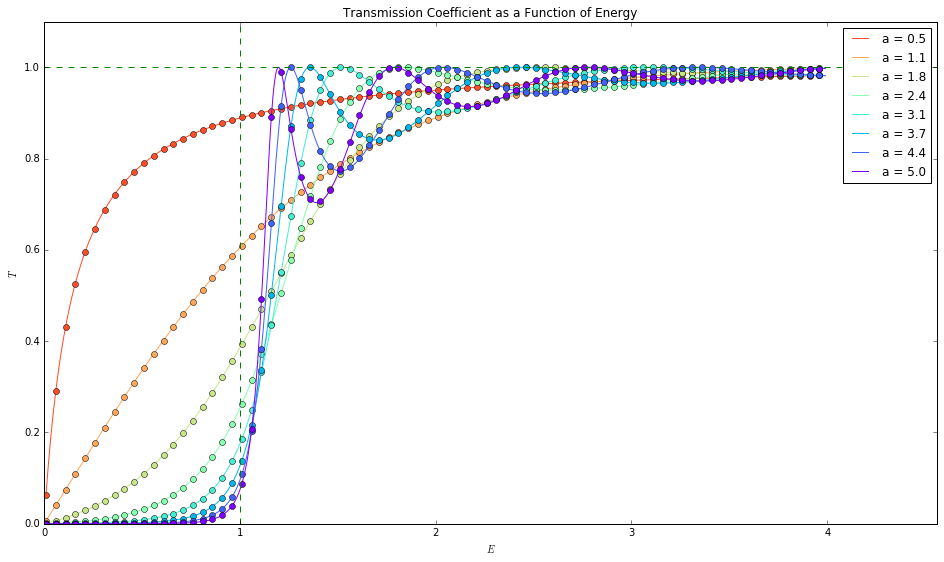

In [14]:
as_ = np.linspace(0.5, 5, 8)
colors = cm.rainbow(1 - as_ / 5)
Es = np.linspace(.01, 3.99,1000)
Es_coarse = np.arange(.01, 4., .05)
#n = 1e3
# choose n such that dx ~ 0.01
n = as_[-1]/0.01

for a, color in zip(as_, colors):
    # plot theoretical value
    plt.plot(Es, [transmission_exact(a=a, E=E) for E in Es], color=color, label='a = %.1f' % a)
    
    # plot numerical data points
    Ts_approx = [scatter(V=rect_potential(a), E=E, x_min=0, x_max=a, n=n)[0] for E in Es_coarse]
    l = plt.plot(Es_coarse, Ts_approx, 'o', color=color)

common_plt('Transmission Coefficient as a Function of Energy', '$E$', '$T$',
           [0,Es_coarse[-1]+0.6], [0,1.1])

Note that E>1 is above the potential.

#### Dependence on Barrier Width

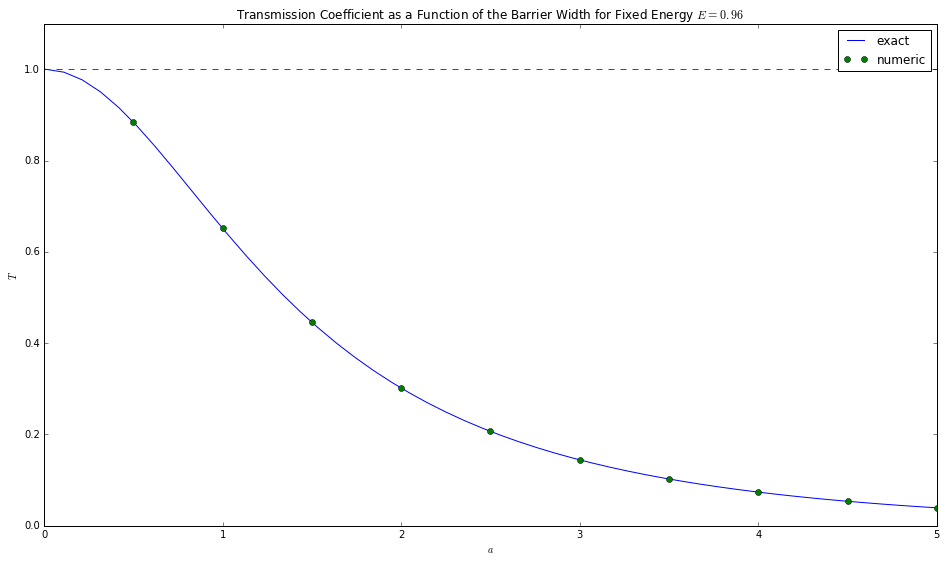

In [15]:
E = .96
as_ = np.linspace(.01, 5)
as_coarse = np.linspace(0.5, 5, 10)
n = as_[-1]/0.01

plt.plot(as_, [transmission_exact(a=a, E=E) for a in as_], label='exact')
plt.plot(as_coarse, [scatter(V=rect_potential(a=a), E=E, x_min=0, x_max=a, n=n)[0] for a in as_coarse], 'o', label='numeric')

common_plt('Transmission Coefficient as a Function of the Barrier Width for Fixed Energy $E = %s$' % E,
           '$a$', '$T$', [0,as_[-1]], [0,1.1], xone=False)

## Parabolic Potential

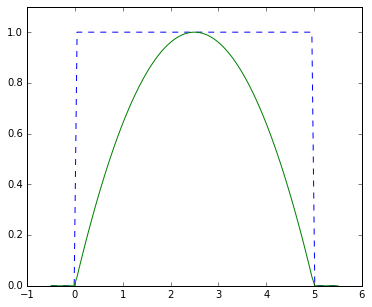

In [16]:
def parabolic_potential(a):
    a = float(a)
    def V(x):
        if 0 < x <= a:
            return 4. * (x / a  - x**2 / a**2)
        return 0.
    return V

common_plt_potential([rect_potential(a=5), '--'], parabolic_potential(a=5))

#### Compare Dependence on Energy

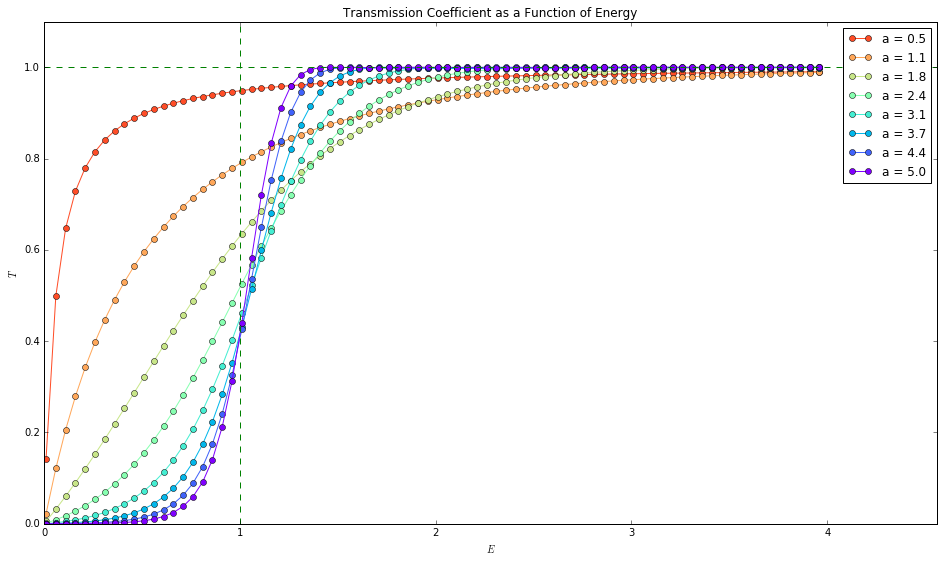

In [17]:
as_ = np.linspace(0.5, 5, 8)
colors = cm.rainbow(1 - as_ / 5)
Es_coarse = np.arange(.01, 4, .05)
n = as_[-1]/0.01

for a, color in zip(as_, colors):
    # plot numerical data points
    Ts_parabolic = [scatter(V=parabolic_potential(a), E=E, x_min=0, x_max=a, n=n)[0] for E in Es_coarse]
    l = plt.plot(Es_coarse, Ts_parabolic, 'o-', color=color, label='a = %.1f' % a)

common_plt('Transmission Coefficient as a Function of Energy', '$E$', '$T$',
           [0,Es_coarse[-1]+0.6], [0,1.1])

This is related to the tunneling current $I\propto T(a)$ in Scanning Tunnelling Microscopy (STM).

#### Compare Dependence on Barrier Width

In [18]:
Es = [.51, .71]
colors = ['blue', 'green']
as_ = np.linspace(.01, 5)
as_coarse = np.linspace(0.5, 5, 10)
n = as_[-1]/0.01

for E, color in zip(Es, colors):
    # plot theoretical value
    plt.plot(as_, [transmission_exact(a=a, E=E) for a in as_], '--', color=color, label='E = %s (rect, theoretical)' % E)
    
    # plot numerical data points
    plt.plot(as_coarse, [scatter(V=parabolic_potential(a=a), E=E, x_min=0, x_max=a, n=n)[0] for a in as_coarse], 'o-', label='E = %s (parabolic)' % E)

common_plt('Transmission Coefficient as a Function of the Barrier Width for Energies E = %s' % ', '.join(map(str, Es)),
           '$a$', '$T$', [0,as_[-1]+0.5], [0,1.1], xone=False)

The numerics confirm our intuition that the parabolic potential transmits "better" than the (analytically solvable) rectangular potential: there is less material to tunnel through.

## Fourth Order Potential

In [19]:
def bound_potential(a):
    a = float(a)
    def V(x):
        if 0 < x <= a:
            return 4*(((x-a/2)/(a/2))**2 - ((x-a/2)/(a/2))**4)
        return 0.
    return V

common_plt_potential([rect_potential(a=5), '--'], bound_potential(a=5), bound_potential(a=3))

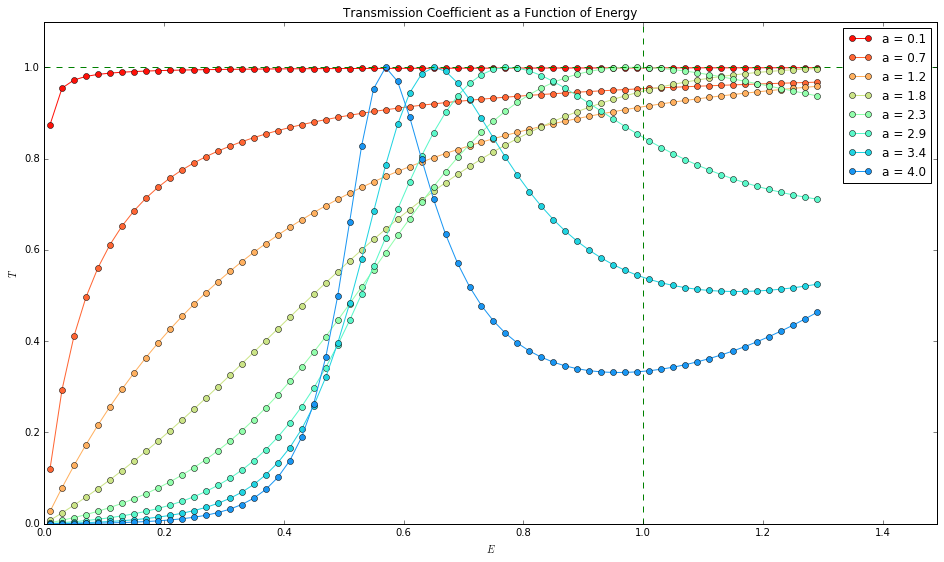

In [20]:
as_ = np.linspace(0.1, 4, 8)
colors = cm.rainbow(1 - as_ / 5)
Es_coarse = np.arange(.01, 1.3, .02)
n = as_[-1]/0.01

for a, color in zip(as_, colors):
    # plot numerical data points
    Ts_parabolic = [scatter(V=bound_potential(a), E=E, x_min=0, x_max=a, n=n)[0] for E in Es_coarse]
    l = plt.plot(Es_coarse, Ts_parabolic, 'o-', color=color, label='a = %.1f' % a)

common_plt('Transmission Coefficient as a Function of Energy', '$E$', '$T$',
           [0,Es_coarse[-1]+0.2], [0,1.1])

Note how the peak transmission reaches 100% for certain energies below 1.  
Explanation: destructive interference and energy conservation (Fabry-Pérot interferometer).

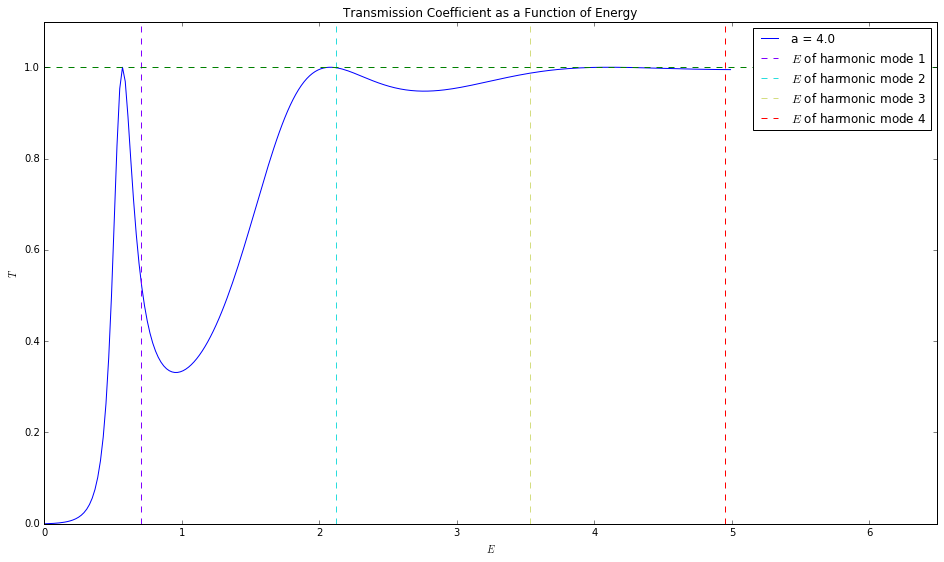

In [21]:
Es_coarse = np.arange(.01, 5.0, .02)
a = 4.0
n = a/0.01

# plot numerical data points
Ts_parabolic = [scatter(V=bound_potential(a), E=E, x_min=0, x_max=a, n=n)[0] for E in Es_coarse]
plt.plot(Es_coarse, Ts_parabolic, '-', label='a = %.1f' % a)

harm_n = 4
colors = iter(cm.rainbow(np.linspace(0,1,harm_n)))
E_harm = lambda n: sqrt(2)*4/a*(n+0.5)
for n in range(harm_n):
    plt.axvline(E_harm(n),linestyle='--', color=next(colors), label="$E$ of harmonic mode %s" % (n+1))

common_plt('Transmission Coefficient as a Function of Energy', '$E$', '$T$',
           [0,Es_coarse[-1]+1.5], [0,1.1], xone=False)

Comparison with the energy levels for the harmonic oscillator.

In [22]:
a = 4.0
n = a/0.01

V = bound_potential(a)
for E,color in zip([0.4,0.57,0.9],['r','g','b']):
    T, _, xs, psis = scatter(V=V, E=E, x_min=-3, x_max=a, n=n, return_xs_psis=True)
    norm = np.sum(np.abs(psis)**2)*a/n
    plt.plot(xs, np.abs(psis)**2/norm, '--', color=color, label='E = %s' % E)
plt.plot(xs, [V(x) for x in xs], color='k')

common_plt('Norm square of wave function', '$x$', '$|\psi|^2$', [-3.5,a+0.5], [0,1.1], xone=False)

Note how the $E=0.9$ wavefunction has a lower amplitude than the $E=0.4$ wavefunction. This is due to destructive interference for this specific width of the barrier.

# Playground

In [14]:
scatter(rect_potential(a=1), E=0.71, x_min=0, x_max=1, n=100000)

(0.54014292192257163, 0.45985707638627388)

In [10]:
def weird_pot(a):
    a = float(a)
    def V(x):
        if 0 < x <= a/2:
            return 1-x/a
        if a/2 < x <= a:
            return 2*x/a - 1
        return 0.
    return V

import ipywidgets as wgt

def iplot(a):
    xs = np.linspace(-0.5, 5.5, num=100)
    plt.plot(xs, [weird_pot(a=a)(x) for x in xs])
    common_plt_potential([rect_potential(a=5), '--'], weird_pot(a=5))

wgt.interact(iplot, a=(0.1,5,0.1))

<function __main__.iplot>

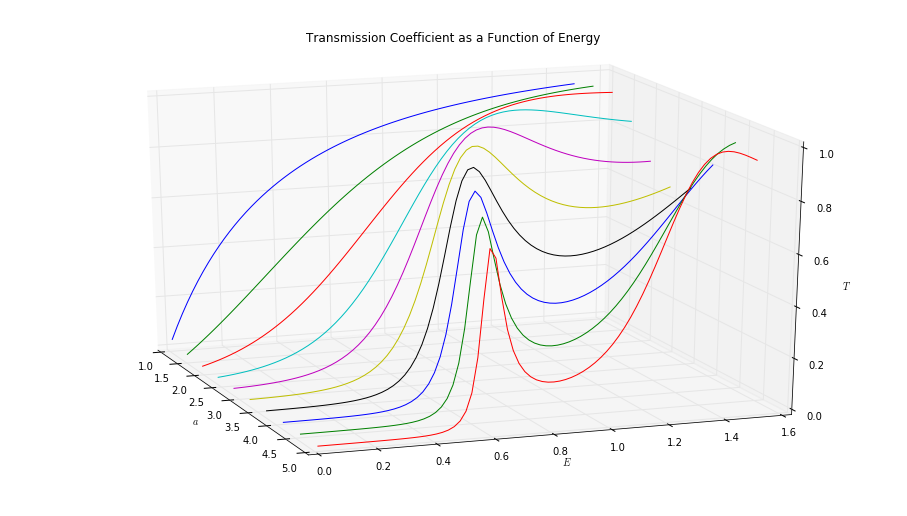

In [24]:
as_ = np.linspace(1, 5, 10)
colors = cm.rainbow(1 - as_ / 5)
Es_coarse = np.arange(.01, 1.5, .02)
#n = as_[-1]/0.01
n = 40

from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')
ax.view_init(elev=20., azim=-20)

for a, color in zip(as_, colors):
    # plot numerical data points
    Ts_parabolic = [scatter(V=weird_pot(a), E=E, x_min=0, x_max=a, n=n)[0] for E in Es_coarse]
    ax.plot(np.full((len(Es_coarse)), a), Es_coarse, Ts_parabolic)

plt.title('Transmission Coefficient as a Function of Energy')
plt.xlabel('$a$')
plt.ylabel('$E$')
ax.set_zlabel('$T$')
plt.show()

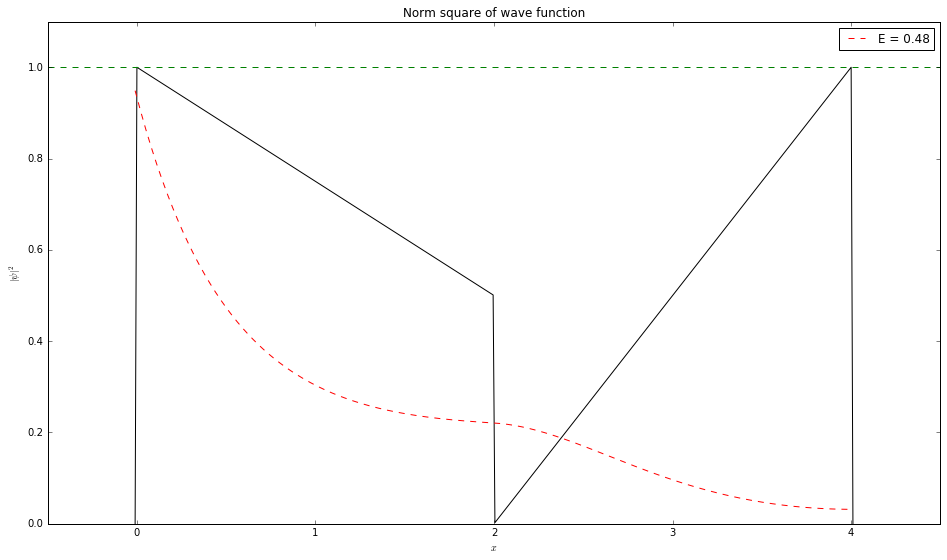

In [11]:
a = 4.0
n = a/0.01

V = weird_pot(a)

xs = []
psis_cache = {}
for i in np.arange(0.1, 0.99, 0.02): # cave: needs to as many elements as the interact(range)
    i = round(i, 2)
    _,_, xs, psis_cache[i] = scatter(V=V, E=i, x_min=0, x_max=a, n=n, return_xs_psis=True)

def iplot(E):
    #psis = psis_cache[E]  # appears to be fast enough without caching all values
    _, _, xs, psis = scatter(V=V, E=E, x_min=0, x_max=a, n=n, return_xs_psis=True)
    plt.plot(xs, [V(x) for x in xs], color='k')
    norm = np.sum(np.abs(psis)**2)*a/n
    plt.plot(xs, np.abs(psis)**2/norm, '--', color='red', label='E = %s' % E)
    common_plt('Norm square of wave function', '$x$', '$|\psi|^2$', [-0.5,a+0.5], [0,1.1], xone=False)

wgt.interact(iplot, E=(0.1, 0.98, 0.02))
